In [1]:
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

In [7]:
def get_risk(prices):
    return (prices / prices.shift(1) - 1).dropna().std().values

def get_return(prices):
    return ((prices / prices.shift(1) - 1).dropna().mean() * np.sqrt(250)).values

symbols = ['BA', 'C', 'AAL', 'NFLX']

start = '01-01-2014'
end = '08-19-2019'

prices = pd.DataFrame(index=pd.date_range(start, end))

for symbol in symbols:
    portfolio = web.DataReader(name=symbol, data_source='yahoo', start=start, end=end)
    close = portfolio[['Adj Close']]
    close = close.rename(columns={'Adj Close': symbol})
    prices = prices.join(close)
    #portfolio.to_csv("{}.csv".format(symbol))


In [14]:
prices.head(10)

,BA,C,AAL,NFLX
2014-01-01,NaN,NaN,NaN,NaN
2014-01-02,117.282707,48.726482,24.074064,51.831429
2014-01-03,118.097916,49.779881,25.194225,51.871429
2014-01-04,NaN,NaN,NaN,NaN
2014-01-05,NaN,NaN,NaN,NaN
2014-01-06,118.775871,50.162086,25.659380,51.367142
2014-01-07,120.577988,50.507008,25.545462,48.500000
2014-01-08,120.844025,51.094299,26.228949,48.712856
2014-01-09,121.968178,51.457863,27.928185,48.150002
2014-01-10,121.770760,51.010395,27.861736,47.448570


In [15]:
prices = prices.dropna()
risk_v = get_risk(prices)
return_v = get_return(prices)


In [17]:
risk_v, return_v

(array([0.01521064, 0.01532276, 0.02302186, 0.02670374]),
 array([0.01351306, 0.00495871, 0.00509746, 0.02554604]))

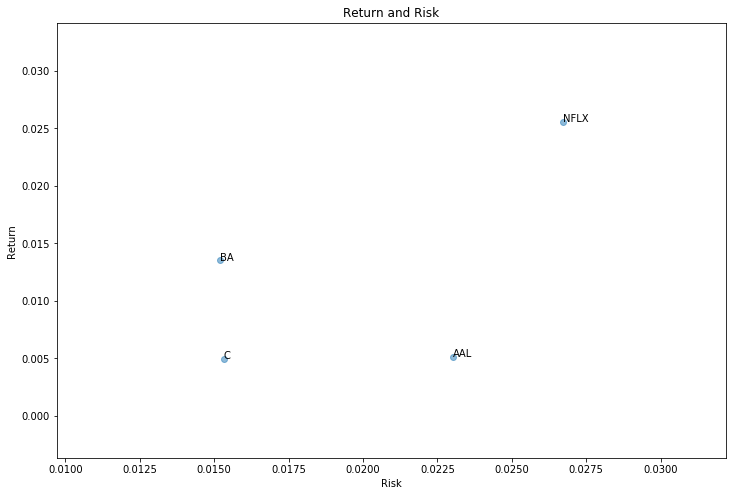

In [22]:

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x=risk_v, y=return_v, alpha=0.5)
ax.set(title='Return and Risk', xlabel='Risk', ylabel='Return')

for i, symbol in enumerate(symbols):
    ax.annotate(symbol, (risk_v[i], return_v[i]))
    
plt.show()

# Return and risk for BA (Boeing), C (Citigroup), AAL (American Airlines Group), NFLX (Netflix)

In [23]:
def random_weights(n):
    weights = np.random.rand(n)
    return weights / sum(weights)

def get_portfolio_risk(weights, normalized_prices):
    portfolio_val = (normalized_prices * weights).sum(axis=1)
    portfolio = pd.DataFrame(index=normalized_prices.index, data={'portfolio': portfolio_val})
    # (portfolio / portfolio.shift(1) - 1) --> calculating return 
    return (portfolio / portfolio.shift(1) - 1).dropna().std().values[0]

def get_portfolio_return(weights, normalized_prices):
    portfolio_val = (normalized_prices * weights).sum(axis=1)
    portfolio = pd.DataFrame(index=normalized_prices.index, data={'portfolio': portfolio_val})
    ret = get_return(portfolio)
    return ret[0]


In [24]:

risk_all = np.array([])
return_all = np.array([])

# for demo purpose, plot 3000 random portoflio
np.random.seed(0)
normalized_prices = prices / prices.ix[0, :]

for _ in range(0, 3000):
    weights = random_weights(len(symbols))
    # weights here refer to the number of shares
    portfolio_val = (normalized_prices * weights).sum(axis=1)
    portfolio = pd.DataFrame(index=prices.index, data={'portfolio': portfolio_val})
    risk = get_risk(portfolio)
    ret = get_return(portfolio)
    risk_all = np.append(risk_all, risk)
    return_all = np.append(return_all, ret)
    p = get_portfolio_risk(weights=weights, normalized_prices=normalized_prices)
    

/Users/munkarkin/environments/ml_dir/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


In [29]:
normalized_prices.head()

,BA,C,AAL,NFLX
2014-01-02,1.000000,1.000000,1.000000,1.000000
2014-01-03,1.006951,1.021619,1.046530,1.000772
2014-01-06,1.012731,1.029463,1.065852,0.991042
2014-01-07,1.028097,1.036541,1.061120,0.935726
2014-01-08,1.030365,1.048594,1.089511,0.939832


In [34]:
weights

array([0.04442279, 0.30773033, 0.34400514, 0.30384174])

In [32]:
portfolio_val.to_frame().head()

,0
2014-01-02,1.000000
2014-01-03,1.023202
2014-01-06,1.029564
2014-01-07,1.013989
2014-01-08,1.028813


In [33]:
portfolio.head()

,portfolio
2014-01-02,1.000000
2014-01-03,1.023202
2014-01-06,1.029564
2014-01-07,1.013989
2014-01-08,1.028813


In [35]:
p

0.017618895852651632

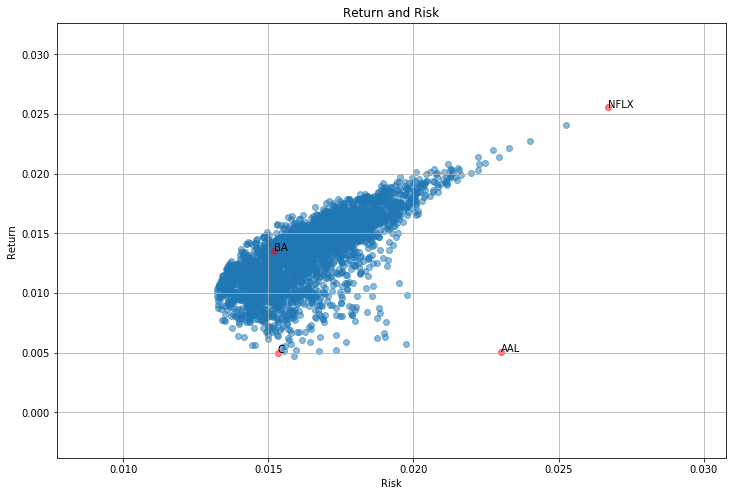

In [26]:

fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(x=risk_all, y=return_all, alpha=0.5)
ax.set(title='Return and Risk', xlabel='Risk', ylabel='Return')

for i, symbol in enumerate(symbols):
    ax.annotate(symbol, (risk_v[i], return_v[i]))
    
ax.scatter(x=risk_v, y=return_v, alpha=0.5, color='red')
ax.set(title='Return and Risk', xlabel='Risk', ylabel='Return')
ax.grid()
plt.show()

## Efficient Frontier
From wikipedia, in modern portfolio theory, the efficient frontier (or portfolio frontier) is an investment portfolio which occupies the ‘efficient’ parts of the risk-return spectrum.

Here we will use scipy’s optimizer to get optimal weights for different targeted return. Note that, we have bounds that make sure weight are in range [0, 1] and constraints to ensure sum of weights is 1, also portfolio return meets our target return. With all this condition, scipy optimizer is able to find the best allocation.

In [36]:
np.ones(len(symbols)) * (1.0 / len(symbols))

array([0.25, 0.25, 0.25, 0.25])

In [37]:
((0.0, 1.0),) * len(symbols)

((0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0))

In [38]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where x is an 1-D array with shape (n,) and `args`
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see here) <op

For inequality constraints,
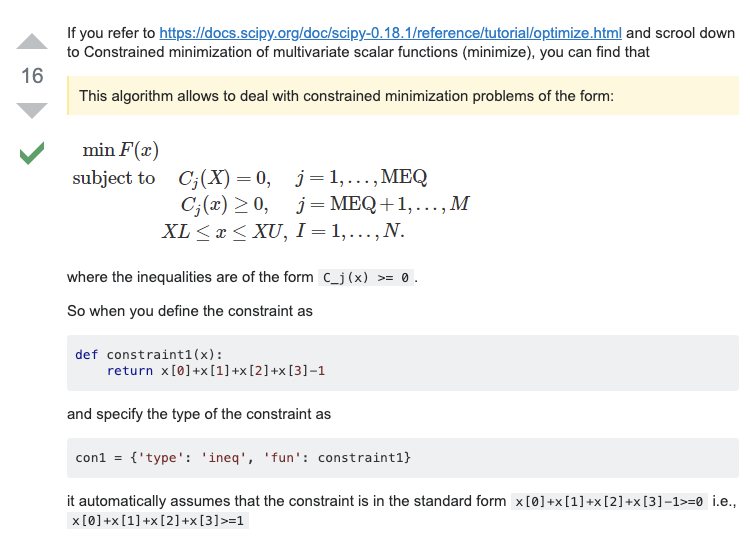

In [46]:
# optimizer
def optimize(prices, symbols, target_return=0.1):
    normalized_prices = prices / prices.ix[0, :]
    init_guess = np.ones(len(symbols)) * (1.0 / len(symbols))
    
    # (min, max) pairs for each element in x
    bounds = ((0.0, 1.0),) * len(symbols)
    
    weights = minimize(get_portfolio_risk, 
                       init_guess,
                       args=(normalized_prices,), 
                       method='SLSQP',
                       options={'disp': False}, # Set to True to print convergence messages.
                       
                       constraints=({'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs)}, # sum(inputs) = 1 
                                    
                                    #  here we impose a constraint where
                                    # target_return = get_portfolio_return(weights=inputs, 
                                    #                                      normalized_prices=normalized_prices)
                                    {'type': 'eq', 'args': (normalized_prices,),
                                     'fun': lambda inputs, normalized_prices:
                                     target_return - get_portfolio_return(weights=inputs,
                                                                          normalized_prices=normalized_prices)}),
                       bounds=bounds)
    
    return weights.x

optimal_risk_all = np.array([])
optimal_return_all = np.array([])

#for target_return in np.arange(0.005, .0402, .0005):
target_return = 0.05
opt_w = optimize(prices=prices, symbols=symbols, target_return=target_return)
optimal_risk_all = np.append(optimal_risk_all, get_portfolio_risk(opt_w, normalized_prices))
optimal_return_all = np.append(optimal_return_all, get_portfolio_return(opt_w, normalized_prices))


/Users/munkarkin/environments/ml_dir/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
opt_w

array([2.54549244e-18, 3.35336935e-16, 1.20604104e-18, 1.00000000e+00])

In [49]:
optimal_risk_all, optimal_return_all

(array([0.02670374]), array([0.02554604]))

Hence, this is saying that if we use the weights above,

We will get a return of 0.0255 ± (0.0267 * 2) or,

2.555 % ± 5.34 % 

Usually we express it in terms of 2 standard deviations away.

In [50]:
target_return = 0.0175
opt_w = optimize(prices=prices, symbols=symbols, target_return=target_return)
optimal_risk_all = np.append(optimal_risk_all, get_portfolio_risk(opt_w, normalized_prices))
optimal_return_all = np.append(optimal_return_all, get_portfolio_return(opt_w, normalized_prices))


/Users/munkarkin/environments/ml_dir/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
opt_w

array([0.65384978, 0.        , 0.        , 0.34615022])

In [52]:
optimal_risk_all, optimal_return_all

(array([0.02670374, 0.01675867]), array([0.02554604, 0.0175    ]))

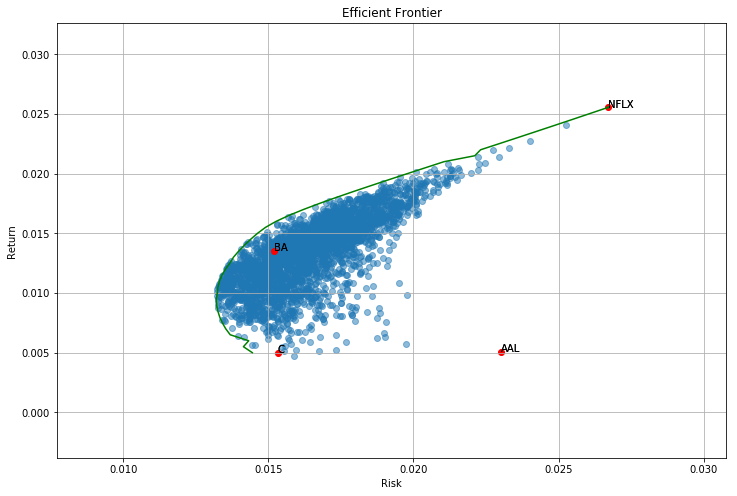

In [43]:

# plotting
fig, ax = plt.subplots(figsize=(12,8))

# random portfolio risk return
ax.scatter(x=risk_all, y=return_all, alpha=0.5)
# optimal portfolio risk return
for i, symbol in enumerate(symbols):
    ax.annotate(symbol, (risk_v[i], return_v[i]))
    
ax.plot(optimal_risk_all, optimal_return_all, '-', color='green')
# symbol risk return
for i, symbol in enumerate(symbols):
    ax.annotate(symbol, (risk_v[i], return_v[i]))
    
ax.scatter(x=risk_v, y=return_v, color='red')
ax.set(title='Efficient Frontier', xlabel='Risk', ylabel='Return')
ax.grid()
plt.savefig('return_risk_efficient_frontier.png', bbox_inches='tight')

The green line indicate the efficient frontier. Now we know the best allocation with a given target return. Next question, what is the best allocation overall? Portfolio performance can be evaluated with return/risk ratio (known as Sharpe Ratio). High Sharpe Ratio indicates good balance of return and risk. This allocation can be found by drawing a Capital Allocation line that tangent to the efficient frontier. The tangent point is the allocation yields highest Sharpe ratio. To learn more, you can take a look at this article on how to find the highest sharpe ratio from the efficient frontier with Capital Allocation Line (CAL).